In [1]:
from scipy import ndimage, sparse
from scipy.linalg import eigh, inv, logm, norm
import scipy.sparse
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob

In [2]:
def edges_rescaling(edges,scale): # edges are mat.data where mat is a sparse scipy matrix
    edges = np.log10(edges) # log rescale weights because they vary over many decades
    edges -= min(edges) # make them positive 
    edges /= max(edges)*1.0/scale # rescale from 0 to scale
    return edges

def build_omegaij(Kdata,Krow,Kcol,m):
    omegaIJ_data = np.zeros(Kdata.shape)
    omegaIJ_data = np.asfarray([Kdata[ind]*(1.0/m[Krow[ind]] + 1.0/m[Kcol[ind]]) for ind in range(omegaIJ_data.shape[0])])
    omegaIJ = sparse.coo_matrix((omegaIJ_data, (Krow, Kcol)), shape=(Krow.max()+1,Kcol.max()+1))
    return omegaIJ
def build_omegai(K,m):
    omegaI = 0.5*np.divide(K.sum(axis=1),m.reshape((m.shape[0],1))) #0.5 to avoid double counting
    return omegaI

def remove_col(mat,index_to_drop): #csr
    to_keep = list(set(range(mat.shape[1]))-set(index_to_drop))    
    mat = mat[:,to_keep]
    return mat
def remove_row(mat,index_to_drop): #csc
    to_keep = list(set(range(mat.shape[0]))-set(index_to_drop))    
    mat = mat[to_keep,:]
    return mat
def remove_2nodes(mat,nodes):
    mat = mat.tocoo()
    todrop1 = np.logical_or((mat.row==nodes[0]),(mat.row==nodes[1])).nonzero()[0]
    todrop2 = np.logical_or((mat.col==nodes[0]),(mat.col==nodes[1])).nonzero()[0]
    todrop = list(set(np.concatenate((todrop1,todrop2))))
    newdata=np.delete(mat.data,todrop)
    newrow=np.delete(mat.row,todrop)
    newcol=np.delete(mat.col,todrop)
    return sparse.coo_matrix((newdata, (newrow, newcol)), shape=mat.shape)
def remove_1node(mat,node):
    mat = mat.tocoo()
    todrop = np.logical_or((mat.row==node[0]),(mat.col==node[0])).nonzero()[0]
    todrop = list(set(todrop))
    newdata=np.delete(mat.data,todrop)
    newrow=np.delete(mat.row,todrop)
    newcol=np.delete(mat.col,todrop)
    return sparse.coo_matrix((newdata, (newrow, newcol)), shape=mat.shape)
def expand(Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol,idxs,m,g):
    for idx in idxs:
        newdata=K.data[idx]
        j=K.col[idx]
        #add (g,j,newdata)
        Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol = expand1(Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol,newdata,m,g,j)
    return Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol
def expand1(Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol,newk,m,i,j):
    Kdata = np.append(Kdata,newk)
    Krow = np.append(Krow,i)
    Kcol = np.append(Kcol,j)
    omegaIJdata = np.append(omegaIJdata,newk*(1.0/m[i]+1.0/m[j]))
    omegaIJrow = np.append(omegaIJrow,i)
    omegaIJcol = np.append(omegaIJcol,j)
    #add symmetric
    Kdata = np.append(Kdata,newk)
    Krow = np.append(Krow,j)
    Kcol = np.append(Kcol,i)
    omegaIJdata = np.append(omegaIJdata,newk*(1.0/m[i]+1.0/m[j]))
    omegaIJrow = np.append(omegaIJrow,j)
    omegaIJcol = np.append(omegaIJcol,i)
    return Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol
def delete_nodes(Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol,idxs): #this is not symm wrt to (i,j)
    Kdata = np.delete(Kdata,idxs)
    Krow = np.delete(Krow,idxs)
    Kcol = np.delete(Kcol,idxs)
    omegaIJdata = np.delete(omegaIJdata,idxs)
    omegaIJrow = np.delete(omegaIJrow,idxs)
    omegaIJcol = np.delete(omegaIJcol,idxs)
    return Kdata,Krow,Kcol,omegaIJdata,omegaIJrow,omegaIJcol

In [56]:
filename='/home/garner1/Work/pipelines/tissue2graph/npz/mat_XY_10nn.npz'
K0 = sparse.load_npz(filename)

N = 1000
K = K0.copy()[:N,:N].tocoo()  #make a copy of the initial data
m = np.ones(K0.shape[0])[:N] #initial masses

# K = K0.copy().tocoo()  #make a copy of the initial data
# m = np.ones(K0.shape[0]) #initial masses

In [57]:
import networkx as nx
import seaborn as sns; sns.set()
sns.set(style='white', rc={'figure.figsize':(50,50)})

init_mat = sparse.coo_matrix((K.data, (K.row, K.col)), shape=(K.row.max()+1, K.col.max()+1))

G = nx.from_scipy_sparse_matrix(init_mat) # if sparse matrix
eset = [(u, v) for (u, v, d) in G.edges(data=True)]
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]

data = np.load('/home/garner1/Work/pipelines/tissue2graph/npz/X-XY_data.npz',allow_pickle=True)
pos = data['XY']

nx.draw_networkx_nodes(G, pos,alpha=0.0)
nx.draw_networkx_edges(G, pos, edgelist=eset,alpha=1.0, width=weights,edge_color='r',style='solid')
plt.axis('off')

plt.savefig('./before_RG_aoki.png',bbox_inches='tight')
plt.close()

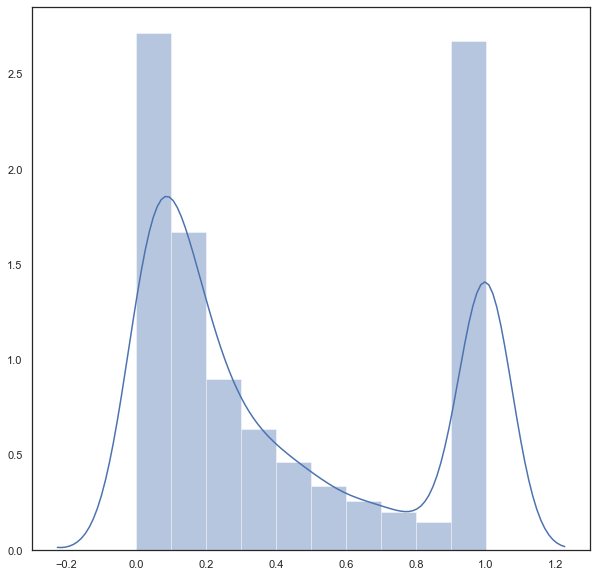

In [58]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.distplot(weights)

In [59]:
omegaIJ = build_omegaij(K.data,K.row,K.col,m)
omegaI = build_omegai(K,m) 

# %%time
'''RG flow'''
# for counter in range(2*N):
condition = True
Imax0 = 0
IJmax0 = 0
for i0 in range(500):
    #Find max btw node and edges
    IJmax = omegaIJ.data.max()
    Imax = omegaI.max()
    #Find max btw node and edges
    print(i0,IJmax,Imax,np.count_nonzero(omegaI),omegaIJ.data.shape[0])
    idx_i0isrow = np.argwhere(K.row==i0) # idxs of (i0,j)
    idx_i0iscol = np.argwhere(K.col==i0) # idx of (i,i0)
    js = np.unique(K.col[idx_i0isrow]) # nn j in (i0,j)
    for i in js:
        for j in js[np.argwhere(js==i)[0][0]+1:]:
            idx_ij = np.intersect1d(np.argwhere(K.row==i),np.argwhere(K.col==j))
            idx_ji = np.intersect1d(np.argwhere(K.row==j),np.argwhere(K.col==i))
            idx_ii0 = np.intersect1d(np.argwhere(K.row==i),np.argwhere(K.col==i0))    
            idx_i0j = np.intersect1d(np.argwhere(K.row==i0),np.argwhere(K.col==j))
            if idx_ii0.shape[0]>0 and idx_i0j.shape[0]>0: # only if edge (i,i0) and (i0,j) exists
                newk = np.sum(np.append(K.data[idx_ij],K.data[idx_ii0]*K.data[idx_i0j]*1.0/(omegaI[i0]*m[i0])))
                #update edge values
                K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = expand1(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,newk,m,i,j)
                #remove old (i,j) and (j,i)
                K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,idx_ij)
                K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,idx_ji)
    #remove i0 from K, omegaIJ
    K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.argwhere(K.row==i0))
    K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col = delete_nodes(K.data,K.row,K.col,omegaIJ.data,omegaIJ.row,omegaIJ.col,np.argwhere(K.col==i0))


0 2.0 3.1326018230170156 1000 9772
1 2.289717138988077 3.1326018230170156 1000 9768
2 3.278503913757267 3.1326018230170156 1000 9769
3 3.395857357693267 3.1326018230170156 1000 9765
4 2.293075513976104 3.1326018230170156 1000 9767
5 2.19117542429453 3.1326018230170156 1000 9753
6 2.191185393355046 3.1326018230170156 1000 9765
7 2.6419010395070464 3.1326018230170156 1000 9760
8 3.046812173820479 3.1326018230170156 1000 9762
9 3.046812173820479 3.1326018230170156 1000 9759
10 3.2466370121139 3.1326018230170156 1000 9754
11 4.519946658483224 3.1326018230170156 1000 9745
12 4.519946658483224 3.1326018230170156 1000 9749
13 4.519946658483224 3.1326018230170156 1000 9739
14 4.519946658483224 3.1326018230170156 1000 9727
15 4.519946658483224 3.1326018230170156 1000 9724
16 4.519946658483224 3.1326018230170156 1000 9719
17 4.519946658483224 3.1326018230170156 1000 9715
18 4.519946658483224 3.1326018230170156 1000 9706
19 4.519946658483224 3.1326018230170156 1000 9708
20 4.519946658483224 3.132

172 2.236014830787663 3.1326018230170156 1000 9547
173 2.236014830787663 3.1326018230170156 1000 9457
174 2.0859141234668814 3.1326018230170156 1000 9399
175 2.0859141234668814 3.1326018230170156 1000 9318
176 2.0859141234668814 3.1326018230170156 1000 9233
177 2.0859141234668814 3.1326018230170156 1000 9200
178 2.296308876308362 3.1326018230170156 1000 9287
179 2.296308876308362 3.1326018230170156 1000 9199
180 2.296308876308362 3.1326018230170156 1000 9137
181 2.296308876308362 3.1326018230170156 1000 9307
182 2.6089829626507357 3.1326018230170156 1000 9272
183 2.6089829626507357 3.1326018230170156 1000 9307
184 2.6089829626507357 3.1326018230170156 1000 9313
185 2.0859141234668814 3.1326018230170156 1000 9486
186 2.0859141234668814 3.1326018230170156 1000 9358
187 2.0859141234668814 3.1326018230170156 1000 9251
188 2.0859141234668814 3.1326018230170156 1000 9163
189 2.0859141234668814 3.1326018230170156 1000 9082
190 2.0859141234668814 3.1326018230170156 1000 9002
191 2.085914123466

337 2.1762215196588617 3.1326018230170156 1000 8450
338 2.1762215196588617 3.1326018230170156 1000 8435
339 2.0777855686733093 3.1326018230170156 1000 8494
340 2.2217301106331675 3.1326018230170156 1000 8654
341 2.2217301106331675 3.1326018230170156 1000 8597
342 2.0777855686733093 3.1326018230170156 1000 8486
343 2.045577840957799 3.1326018230170156 1000 8620
344 2.045577840957799 3.1326018230170156 1000 8635
345 2.045577840957799 3.1326018230170156 1000 8767
346 2.045577840957799 3.1326018230170156 1000 8711
347 2.045577840957799 3.1326018230170156 1000 8755
348 2.045577840957799 3.1326018230170156 1000 8786
349 2.045577840957799 3.1326018230170156 1000 8693
350 2.0 3.1326018230170156 1000 8658
351 2.151230870191463 3.1326018230170156 1000 8701
352 2.151230870191463 3.1326018230170156 1000 8618
353 2.151230870191463 3.1326018230170156 1000 8548
354 2.0 3.1326018230170156 1000 8439
355 2.021545566432451 3.1326018230170156 1000 8561
356 2.021545566432451 3.1326018230170156 1000 8665
35

In [60]:
fixed_mat = sparse.coo_matrix((K.data, (K.row, K.col)), shape=(K.row.max()+1, K.col.max()+1))

import networkx as nx
import seaborn as sns; sns.set()
sns.set(style='white', rc={'figure.figsize':(50,50)})
G = nx.from_scipy_sparse_matrix(fixed_mat) # if sparse matrix
eset = [(u, v) for (u, v, d) in G.edges(data=True)]
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos,alpha=0.0)
nx.draw_networkx_edges(G, pos, edgelist=eset,alpha=1.0, width=weights,edge_color='r',style='solid')
plt.axis('off')

plt.savefig('./after_RG_aoki.png',bbox_inches='tight')
plt.close()


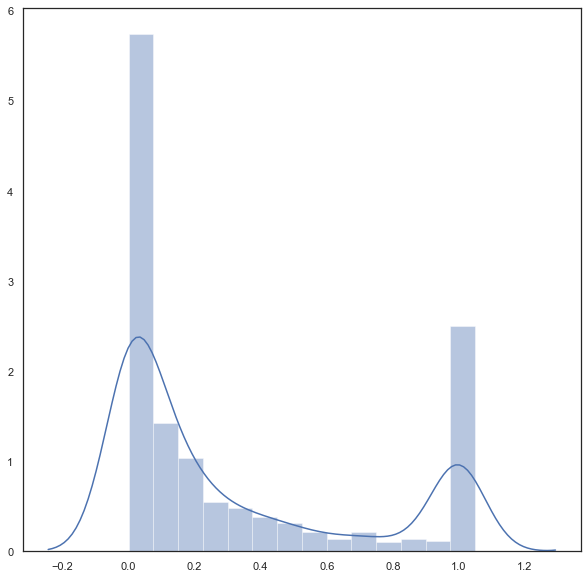

In [61]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.distplot(weights)